- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [211]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [190]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [191]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [192]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [193]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, model_name, lr, batch_size):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # wrap them in Variable
                #inputs, labels = Variable(inputs), Variable(labels)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if epoch % 1000 == 999:    # every 1000 mini-batches...
                    # ...log a Matplotlib Figure showing the model's predictions on a
                    # random mini-batch
                    writer.add_figure('predictions vs. actuals',
                                    plot_classes_preds(net, inputs, labels),
                                    global_step=epoch * len(trainloader) + i)
                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    print()
    print('==== END ====')
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [194]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [195]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [196]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [197]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() 
        #img = images
        self.fc=nn.Linear(512,3)

    
    def forward(self,x):     
        x=x.view(512,7*7).mean(1).view(1,-1)
        x=self.fc(x)
        return  F.softmax(x,dim=1)

In [198]:
trainable_parameters = []
for name, p in model_ft.named_parameters():
    if "fc" in name:
        trainable_parameters.append(p)

In [199]:
params = list(Net().parameters())
weight = np.squeeze(params[-1].data.numpy())

In [200]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['squeezenet']
lrs = [1e-4]
_epoch = [500]
batch_sizes = [16]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                               
                print()
                print()
                print()
                print('='*60)
                print('==== INITIALIZING WITH PARAMETERS: ====')
                print()
                print(f'model -> {_model}')
                print(f'epochs -> {_epochs}')
                print(f'lr -> {_lrs}')
                print(f'batch size -> {_batch}')
                print()
                
                feature_extract = True
                
                #teste heat map
                mod = nn.Sequential(*list(model_ft.children())[:-1])
                
                model_ft=nn.Sequential(mod,Net())
                
                model_ft, input_size = initialize_model(_model, num_classes, 
                                                        feature_extract, use_pretrained=True)
                
                # Send the model to GPU
                model_ft = model_ft.to(device)

                print('-'*20)
                params_to_update = model_ft.parameters()
                print("Params to learn:")
                if feature_extract:
                    params_to_update = []
                    for name,param in model_ft.named_parameters():
                        if param.requires_grad == True:
                            params_to_update.append(param)
                            print("\t",name)
                else:
                    for name,param in model_ft.named_parameters():
                        if param.requires_grad == True:
                            print("\t",name)

                print()
                
                print('-'*20)
                
                print()
                print('== Epochs ==')
                
                optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                criterion = nn.CrossEntropyLoss()

                model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                             num_epochs=_epochs, model_name=_model, lr=_lrs, batch_size=_batch)




==== INITIALIZING WITH PARAMETERS: ====

model -> squeezenet
epochs -> 500
lr -> 0.0001
batch size -> 16

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/499
----------
train Loss: 0.4416 Acc: 0.8411
val Loss: 0.3257 Acc: 0.8804

Epoch 1/499
----------
train Loss: 0.2505 Acc: 0.9177
val Loss: 0.2059 Acc: 0.9377

Epoch 2/499
----------
train Loss: 0.2168 Acc: 0.9281
val Loss: 0.1874 Acc: 0.9435

Epoch 3/499
----------
train Loss: 0.1996 Acc: 0.9332
val Loss: 0.1648 Acc: 0.9469

Epoch 4/499
----------
train Loss: 0.1859 Acc: 0.9377
val Loss: 0.1453 Acc: 0.9568

Epoch 5/499
----------
train Loss: 0.1792 Acc: 0.9394
val Loss: 0.1403 Acc: 0.9589

Epoch 6/499
----------
train Loss: 0.1721 Acc: 0.9418
val Loss: 0.1404 Acc: 0.9539

Epoch 7/499
----------
train Loss: 0.1683 Acc: 0.9425
val Loss: 0.1286 Acc: 0.9610

Epoch 8/499
----------
train Loss: 0.1614 Acc: 0.9436
val Loss: 0.1325 Acc: 0.9597

Epoch 9/499
-------

train Loss: 0.1037 Acc: 0.9640
val Loss: 0.0804 Acc: 0.9751

Epoch 94/499
----------
train Loss: 0.1056 Acc: 0.9630
val Loss: 0.0810 Acc: 0.9714

Epoch 95/499
----------
train Loss: 0.1037 Acc: 0.9637
val Loss: 0.0816 Acc: 0.9747

Epoch 96/499
----------
train Loss: 0.1039 Acc: 0.9612
val Loss: 0.0801 Acc: 0.9743

Epoch 97/499
----------
train Loss: 0.1087 Acc: 0.9612
val Loss: 0.0826 Acc: 0.9726

Epoch 98/499
----------
train Loss: 0.1060 Acc: 0.9634
val Loss: 0.0790 Acc: 0.9755

Epoch 99/499
----------
train Loss: 0.1033 Acc: 0.9650
val Loss: 0.0812 Acc: 0.9738

Epoch 100/499
----------
train Loss: 0.1060 Acc: 0.9617
val Loss: 0.0850 Acc: 0.9701

Epoch 101/499
----------
train Loss: 0.1009 Acc: 0.9655
val Loss: 0.1138 Acc: 0.9585

Epoch 102/499
----------
train Loss: 0.1044 Acc: 0.9632
val Loss: 0.0912 Acc: 0.9705

Epoch 103/499
----------
train Loss: 0.1024 Acc: 0.9646
val Loss: 0.1096 Acc: 0.9601

Epoch 104/499
----------
train Loss: 0.1017 Acc: 0.9643
val Loss: 0.1038 Acc: 0.9626


val Loss: 0.0858 Acc: 0.9714

Epoch 189/499
----------
train Loss: 0.0995 Acc: 0.9655
val Loss: 0.0768 Acc: 0.9768

Epoch 190/499
----------
train Loss: 0.0995 Acc: 0.9631
val Loss: 0.0731 Acc: 0.9763

Epoch 191/499
----------
train Loss: 0.0928 Acc: 0.9668
val Loss: 0.0762 Acc: 0.9776

Epoch 192/499
----------
train Loss: 0.0987 Acc: 0.9644
val Loss: 0.0794 Acc: 0.9751

Epoch 193/499
----------
train Loss: 0.0941 Acc: 0.9664
val Loss: 0.0757 Acc: 0.9763

Epoch 194/499
----------
train Loss: 0.0964 Acc: 0.9658
val Loss: 0.0725 Acc: 0.9776

Epoch 195/499
----------
train Loss: 0.0977 Acc: 0.9630
val Loss: 0.0802 Acc: 0.9701

Epoch 196/499
----------
train Loss: 0.0947 Acc: 0.9637
val Loss: 0.0762 Acc: 0.9738

Epoch 197/499
----------
train Loss: 0.0977 Acc: 0.9657
val Loss: 0.0746 Acc: 0.9743

Epoch 198/499
----------
train Loss: 0.0948 Acc: 0.9672
val Loss: 0.0835 Acc: 0.9730

Epoch 199/499
----------
train Loss: 0.0914 Acc: 0.9691
val Loss: 0.0816 Acc: 0.9685

Epoch 200/499
----------

train Loss: 0.0898 Acc: 0.9675
val Loss: 0.0710 Acc: 0.9792

Epoch 285/499
----------
train Loss: 0.0904 Acc: 0.9680
val Loss: 0.0698 Acc: 0.9792

Epoch 286/499
----------
train Loss: 0.0937 Acc: 0.9664
val Loss: 0.0715 Acc: 0.9801

Epoch 287/499
----------
train Loss: 0.0874 Acc: 0.9670
val Loss: 0.0726 Acc: 0.9755

Epoch 288/499
----------
train Loss: 0.0874 Acc: 0.9677
val Loss: 0.0702 Acc: 0.9784

Epoch 289/499
----------
train Loss: 0.0893 Acc: 0.9700
val Loss: 0.0724 Acc: 0.9747

Epoch 290/499
----------
train Loss: 0.0895 Acc: 0.9693
val Loss: 0.0786 Acc: 0.9705

Epoch 291/499
----------
train Loss: 0.0902 Acc: 0.9685
val Loss: 0.0709 Acc: 0.9772

Epoch 292/499
----------
train Loss: 0.0908 Acc: 0.9672
val Loss: 0.0756 Acc: 0.9734

Epoch 293/499
----------
train Loss: 0.0923 Acc: 0.9675
val Loss: 0.0698 Acc: 0.9780

Epoch 294/499
----------
train Loss: 0.0912 Acc: 0.9665
val Loss: 0.0699 Acc: 0.9772

Epoch 295/499
----------
train Loss: 0.0861 Acc: 0.9691
val Loss: 0.0696 Acc: 0

val Loss: 0.0678 Acc: 0.9784

Epoch 380/499
----------
train Loss: 0.0876 Acc: 0.9676
val Loss: 0.0702 Acc: 0.9763

Epoch 381/499
----------
train Loss: 0.0883 Acc: 0.9679
val Loss: 0.0684 Acc: 0.9784

Epoch 382/499
----------
train Loss: 0.0847 Acc: 0.9686
val Loss: 0.0703 Acc: 0.9763

Epoch 383/499
----------
train Loss: 0.0860 Acc: 0.9681
val Loss: 0.0701 Acc: 0.9751

Epoch 384/499
----------
train Loss: 0.0908 Acc: 0.9658
val Loss: 0.0691 Acc: 0.9780

Epoch 385/499
----------
train Loss: 0.0909 Acc: 0.9673
val Loss: 0.0759 Acc: 0.9743

Epoch 386/499
----------
train Loss: 0.0920 Acc: 0.9666
val Loss: 0.0692 Acc: 0.9772

Epoch 387/499
----------
train Loss: 0.0861 Acc: 0.9692
val Loss: 0.0699 Acc: 0.9763

Epoch 388/499
----------
train Loss: 0.0902 Acc: 0.9681
val Loss: 0.0693 Acc: 0.9768

Epoch 389/499
----------
train Loss: 0.0880 Acc: 0.9696
val Loss: 0.0682 Acc: 0.9780

Epoch 390/499
----------
train Loss: 0.0903 Acc: 0.9678
val Loss: 0.0677 Acc: 0.9784

Epoch 391/499
----------

train Loss: 0.0856 Acc: 0.9680
val Loss: 0.0771 Acc: 0.9751

Epoch 476/499
----------
train Loss: 0.0828 Acc: 0.9710
val Loss: 0.0687 Acc: 0.9780

Epoch 477/499
----------
train Loss: 0.0836 Acc: 0.9679
val Loss: 0.0715 Acc: 0.9776

Epoch 478/499
----------
train Loss: 0.0919 Acc: 0.9680
val Loss: 0.0668 Acc: 0.9788

Epoch 479/499
----------
train Loss: 0.0862 Acc: 0.9699
val Loss: 0.0687 Acc: 0.9780

Epoch 480/499
----------
train Loss: 0.0859 Acc: 0.9691
val Loss: 0.0706 Acc: 0.9784

Epoch 481/499
----------
train Loss: 0.0818 Acc: 0.9708
val Loss: 0.0687 Acc: 0.9776

Epoch 482/499
----------
train Loss: 0.0872 Acc: 0.9676
val Loss: 0.0705 Acc: 0.9755

Epoch 483/499
----------
train Loss: 0.0875 Acc: 0.9669
val Loss: 0.0688 Acc: 0.9772

Epoch 484/499
----------
train Loss: 0.0873 Acc: 0.9672
val Loss: 0.0671 Acc: 0.9784

Epoch 485/499
----------
train Loss: 0.0837 Acc: 0.9688
val Loss: 0.0674 Acc: 0.9801

Epoch 486/499
----------
train Loss: 0.0860 Acc: 0.9699
val Loss: 0.0684 Acc: 0

In [201]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


[[791   0   0]
 [  1 772  26]
 [  4  17 798]]



In [202]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


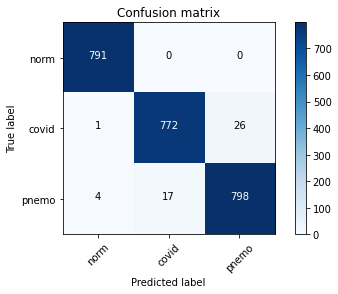

In [203]:
plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [204]:
from sklearn import metrics

In [205]:
#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

Sensitivity or recall total
0.9800747198007472

Sensitivity or recall per classes
[1.   0.97 0.97]

Precision
[0.99 0.98 0.97]

F1 Score
[1.   0.97 0.97]


In [206]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

<Figure size 432x288 with 0 Axes>

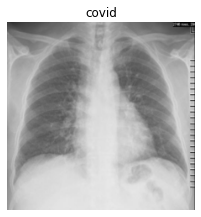

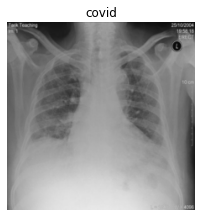

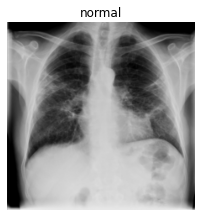

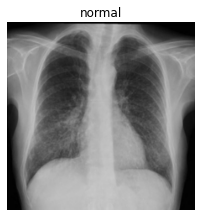

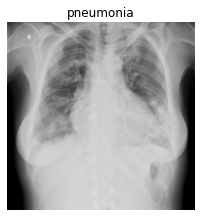

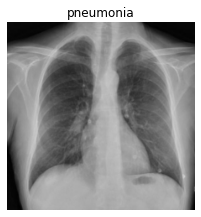

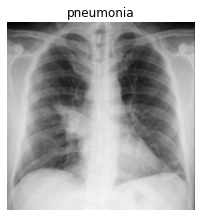

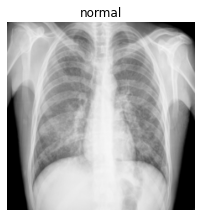

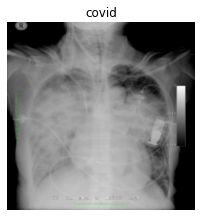

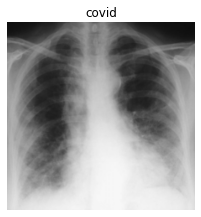

In [270]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [223]:
savePath = "test_model.pth"
torch.save(model_ft.state_dict(), savePath)

In [225]:
import io, os
import requests
from PIL import Image
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets
import numpy as np
import cv2
import pdb

In [226]:
finalconv_name = 'features'
model_ft.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
model_ft.load_state_dict(torch.load("test_model.pth",map_location='cpu'))

In [227]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [228]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [261]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# get the softmax weight
params = params_to_update
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [262]:
img_pil = Image.open("/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-1.png").convert('RGB') # you can change image at here

img_tensor = preprocess(img_pil).cuda()
img_variable = Variable(img_tensor.unsqueeze(0))
logit = model_ft(img_variable)

h_x = F.softmax(logit, dim=1).data.squeeze().cuda()
probs, idx = h_x.sort(0, True)
probs = probs.cpu().numpy()
idx = idx.cpu().numpy()

In [263]:
org_img = np.array(img_pil)

In [264]:
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
org_img = np.array(img_pil,dtype=np.uint8)
org_img = org_img[:, :, ::-1].copy()
height, width, _ = org_img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + org_img * 0.5
cv2.imwrite('result.jpg', result) # save result

True

In [266]:
# check result by opencv 
norm_result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX,dtype=cv2.CV_8UC1)
concat_image = np.hstack((org_img,norm_result))
concat_image = cv2.resize(concat_image, dsize=(0, 0), fx=0.5, fy=0.5)
cv2.imshow('result',concat_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/highgui/src/window.cpp:632: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [208]:
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [209]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [210]:
#for fname in test_dir+'covid':

fname = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'    
img_pil = Image.open(fname).convert('RGB')
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0)).cuda()
logit = model_ft(img_variable).cuda()

h_x = F.softmax(logit, dim=1).data.squeeze().cpu()

probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy().argmax() 
idx = idx.numpy()

predlist.append(idx[0]) # parei aqui
predicted =  train_loader.dataset.classes[idx[0]]

print("Target: " + fname + " | Predicted: " +  predicted) 

features_blobs = mod(img_variable)
features_blobs1 = features_blobs.cpu().detach().numpy()
CAMs = return_CAM(features_blobs1, weight, [idx[0]])

readImg = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = cv2.imread(readImg)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.5 + img * 0.5

cv2.imwrite("image_1", result)

AttributeError: 'Tensor' object has no attribute 'append'

In [39]:
from fastai.vision import *
from fastai.basics import *

model_ft.fit_one_cicle(2, max_lr=slice(2e-5, 1e-4))

AttributeError: 'SqueezeNet' object has no attribute 'fit_one_cicle'

In [ ]:
def images_to_probs(model_ft, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
     outputs = model_ft(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

TypeError: Invalid shape () for image data

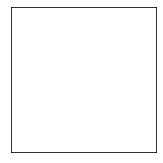

In [79]:

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(12, 48))
for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(predlist[idx])
    ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
        classes[predlist[idx]],
        classes[lbllist[idx]]),
        color="red")

In [ ]:
#roc curve
fpr, tpr, tresholds = metrics.roc_curve(lbllist.numpy(), predlist.numpy())
plt.plot(fpr, tpr)
plt.xlim[0.0, 1.0]
plt.ylim[0.0, 1.0]
plt.title('Roc Curve')
plt.xlabel('False posite rate')
plt.ylabel('True posite rate')
plt.grid(true)

In [ ]:
# test-the-model
model_ft.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['val']:
        images = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model_ft.state_dict(), 'model.ckpt')

![Small confusion matrix](cf.png)

In [16]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[100.          96.74593242  97.19169719]


![Small confusion matrix](cf2.png)

In [17]:
#quem são? listar!
#model_ft, hist

print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [18]:
print(hist)

[tensor(0.9274, device='cuda:0', dtype=torch.float64), tensor(0.9465, device='cuda:0', dtype=torch.float64), tensor(0.9415, device='cuda:0', dtype=torch.float64), tensor(0.9502, device='cuda:0', dtype=torch.float64), tensor(0.9552, device='cuda:0', dtype=torch.float64), tensor(0.9577, device='cuda:0', dtype=torch.float64), tensor(0.9560, device='cuda:0', dtype=torch.float64), tensor(0.9502, device='cuda:0', dtype=torch.float64), tensor(0.9593, device='cuda:0', dtype=torch.float64), tensor(0.9593, device='cuda:0', dtype=torch.float64), tensor(0.9614, device='cuda:0', dtype=torch.float64), tensor(0.9622, device='cuda:0', dtype=torch.float64), tensor(0.9622, device='cuda:0', dtype=torch.float64), tensor(0.9639, device='cuda:0', dtype=torch.float64), tensor(0.9647, device='cuda:0', dtype=torch.float64), tensor(0.9589, device='cuda:0', dtype=torch.float64), tensor(0.9643, device='cuda:0', dtype=torch.float64), tensor(0.9668, device='cuda:0', dtype=torch.float64), tensor(0.9655, device='cuda

In [19]:
type(model_ft)

torchvision.models.squeezenet.SqueezeNet

In [20]:
type(hist)

list

In [21]:
shape(model_ft)

NameError: name 'shape' is not defined

In [22]:
shape(hist)

NameError: name 'shape' is not defined

In [23]:
model_ft.shape

AttributeError: 'SqueezeNet' object has no attribute 'shape'

In [24]:
model_ft.hist

AttributeError: 'SqueezeNet' object has no attribute 'hist'